In [1]:
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('datasets/combined.csv')
num = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit']
cate = ['Term', 'Years in current job', 'Home Ownership', 'Purpose', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens']
target = 'Loan Status'

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
data[num] = scaler.fit_transform(data[num])

ohe = OneHotEncoder(sparse=False)
ohe_data = ohe.fit_transform(data[cate])
feature_names = ohe.get_feature_names_out(cate)
ohe_df = pd.DataFrame(ohe_data, columns=feature_names)

pred = pd.concat([data[num], ohe_df], axis=1)
pred.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Current Credit Balance,Maximum Open Credit,Term_Long Term,Term_Short Term,...,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding,Number of Credit Problems_0,Number of Credit Problems_>= 1,Bankruptcies_0,Bankruptcies_>= 1,Tax Liens_0,Tax Liens_>= 1
0,0.785256,-0.287916,-0.206719,-1.130710,-0.075000,-1.023820,-0.109559,-0.319168,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.240210,0.136230,-0.648519,-0.816379,-0.856869,-0.397137,0.035061,-0.407626,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.484801,0.454339,-0.186254,-0.628059,0.285862,0.438441,-0.654448,-0.748851,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.361462,-1.383625,1.498528,0.067518,0.736940,-1.441609,0.964498,0.091505,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.494247,0.772448,0.145259,1.904886,-0.571186,1.900703,2.158861,1.476592,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pred,
    data['Loan Status'],
    test_size=0.25,
    random_state=42
)

In [11]:
# Train a neural network on the data
model = MLPClassifier(random_state=42, max_iter=500).fit(X_train, y_train)

# Calculate permutation importances
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get importance in descending order
indices = np.argsort(result.importances_mean)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in range(X_train.shape[1]):
    print(f"{i+1}. {pred.columns[indices[i]]} (importance: {result.importances_mean[indices[i]]})")

Feature ranking:
1. Annual Income (importance: 0.025048812235600394)
2. Current Loan Amount (importance: 0.024918646273999357)
3. Home Ownership_Home Mortgage (importance: 0.01767816465994142)
4. Home Ownership_Rent (importance: 0.017190042303937524)
5. Monthly Debt (importance: 0.012260006508298083)
6. Current Credit Balance (importance: 0.011885779368695093)
7. Number of Credit Problems_>= 1 (importance: 0.01013667425968109)
8. Maximum Open Credit (importance: 0.008875691506671012)
9. Term_Short Term (importance: 0.00845265213146763)
10. Credit Score (importance: 0.007606573381060844)
11. Number of Open Accounts (importance: 0.007248616986657986)
12. Number of Credit Problems_0 (importance: 0.005613407094044909)
13. Years in current job_10+ years (importance: 0.004889358932639099)
14. Years of Credit History (importance: 0.004775463716238193)
15. Term_Long Term (importance: 0.004604620891636835)
16. Purpose_Debt Consolidation (importance: 0.004051415554832416)
17. Years in current jo

In [6]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.13      0.19      2832
           1       0.78      0.93      0.85      9460

    accuracy                           0.75     12292
   macro avg       0.57      0.53      0.52     12292
weighted avg       0.69      0.75      0.70     12292



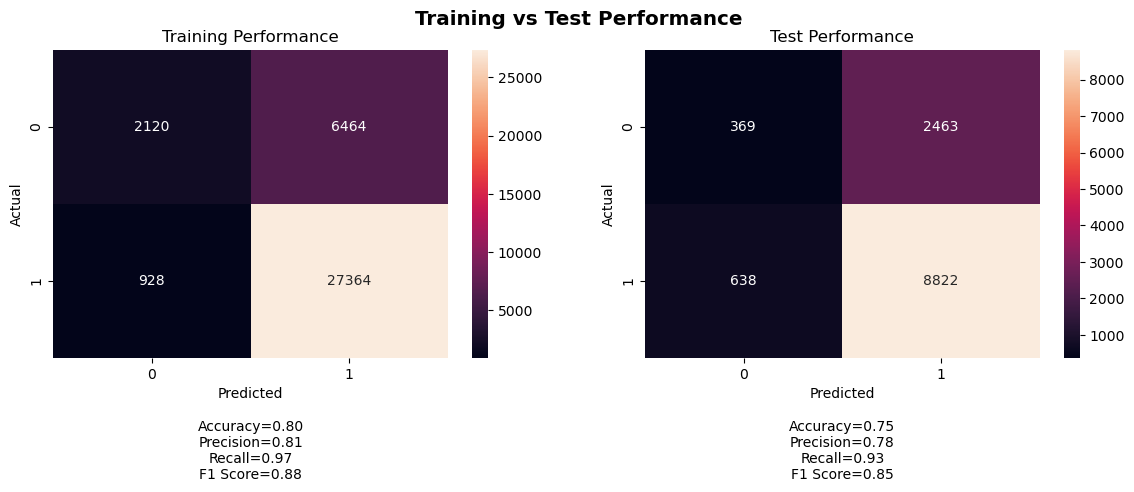

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
    
f, ax = plt.subplots(ncols=2, figsize=(14, 4))
f.suptitle('Training vs Test Performance', fontweight='bold', fontsize='x-large')

# Training set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
cf_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf_train, fmt='.0f', annot=True, ax=ax[0])
    
# Calculate metrics
accuracy_train = np.trace(cf_train) / float(np.sum(cf_train))
precision_train = cf_train[1,1] / sum(cf_train[:,1])
recall_train = cf_train[1,1] / sum(cf_train[1,:])
f1_score_train = 2 * precision_train * recall_train / (precision_train + recall_train)

stats_text_train = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
    accuracy_train, precision_train, recall_train, f1_score_train)

ax[0].set(xlabel='Predicted' + stats_text_train, 
          ylabel='Actual', title='Training Performance')

# Test set
cf_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_test, fmt='.0f', annot=True, ax=ax[1])

# Calculate metrics
accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
precision_test = cf_test[1,1] / sum(cf_test[:,1])
recall_test = cf_test[1,1] / sum(cf_test[1,:])
f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)

stats_text_test = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
    accuracy_test, precision_test, recall_test, f1_score_test)

ax[1].set(xlabel='Predicted' + stats_text_test, 
          ylabel='Actual', title='Test Performance')

plt.show()